In [101]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import types as sqltypes, create_engine
from langdetect import detect
from googletrans import Translator
import eli5
from sklearn.feature_extraction.text import CountVectorizer


# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

import re
import pickle
import os
from dotenv import load_dotenv



**1.** Recopilar los tweets donde se mencione la cuenta de @TheBridge_Tech desde el
día que comenzaste el bootcamp (21 Noviembre) hasta el último día de clase (7
Marzo).

In [2]:
tweets = []

In [ ]:
query = "(@TheBridge_Tech) until:2023-03-07 since:2022-11-21"

for tweet in sntwitter.TwitterSearchScraper(query).get_items():
  tweets.append([tweet.id, tweet.content, tweet.date, tweet.user.id, tweet.user.username, tweet.user.displayname, tweet.retweetCount, tweet.replyCount, tweet.likeCount, tweet.quoteCount ])

df = pd.DataFrame(tweets, columns=['id', 'content', 'date', 'user_id', 'user_username', 'user_displayname', 'retweetCount', 'replyCount', 'likeCount', 'quoteCount'])
df

In [117]:
df = pd.read_csv('./data/tweets.csv')
df.head()

,id,content,date,user_id,user_username,user_displayname,retweetCount,replyCount,likeCount,quoteCount
0,1632767114380492803,"¡Evento #desarrolloweb en #Sevilla con Diego Freniche Brito, Developer Advocate en @MongoDB!\n\nCambiamos de ubicación ¡Te esperamos en @espacio_RES!\n\n📅16 marzo\n⏰18 h\n📍En @espacio_RES \n\nEntradas 👉https://t.co/MJ21xSfIX0 https://t.co/bYJuYAaZ6N",2023-03-06 15:36:30+00:00,1162694149956603904,TheBridge_Tech,The Bridge,3,0,4,0
1,1632746286133702658,"¡Súper contentos de participar! Las temáticas prometen, sin duda 🤩 ¡No te lo pierdas! \n\n📍Universidad @pablodeolavide Sevilla\n🎟Entradas https://t.co/jFvxqPvKTO",2023-03-06 14:13:44+00:00,1162694149956603904,TheBridge_Tech,The Bridge,1,0,1,0
2,1632692123412594688,Las inscripciones se realizarán por Eventbrite. Cualquier duda estamos por MD o al correo info@esoliupo.es\nhttps://t.co/xhVr7VXcF3\n\n@epsUPO @TheBridge_Tech,2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,0,0,0,0
3,1632692120719859712,"¡Por fin podemos publicar el cartel con los ponentes para el #cybersecTalks! Si estás interesadx en alguna de las temáticas que aparecen no dudes en venir, es totalmente gratuito gracias al patrocinio de @TheBridge_Tech y la colaboración de @epsUPO @pablodeolavide \n(+ info abajo) https://t.co/JF85MDGmXc",2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,3,1,5,1
4,1632664546665025536,"Encuentro de la @mlopscommunity en Madrid: ""MLOPs: desde las trincheras"" https://t.co/CHojEAs7ij en @TheBridge_Tech Ven a conocer la práctica #MLOps en Correcto., @Busuu @wallapop https://t.co/odie5CAuHU",2023-03-06 08:48:56+00:00,41545659,nodosenlared,Mario Lopez de Avila,1,0,3,0


- Ya disponemos de la base de datos, procedemos a realizar la división de la misma y breve análisis para saber su composición y si está en condiciones de ser analizada o debe pasar por prepocesamiento de datos.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                175 non-null    int64              
 1   content           175 non-null    object             
 2   date              175 non-null    datetime64[ns, UTC]
 3   user_id           175 non-null    int64              
 4   user_username     175 non-null    object             
 5   user_displayname  175 non-null    object             
 6   retweetCount      175 non-null    int64              
 7   replyCount        175 non-null    int64              
 8   likeCount         175 non-null    int64              
 9   quoteCount        175 non-null    int64              
dtypes: datetime64[ns, UTC](1), int64(6), object(3)
memory usage: 13.8+ KB


In [5]:
df.describe()

,id,user_id,retweetCount,replyCount,likeCount,quoteCount
count,1.750000e+02,1.750000e+02,175.000000,175.000000,175.000000,175.000000
mean,1.612209e+18,6.209114e+17,1.640000,0.262857,5.005714,0.137143
std,1.112227e+16,5.725346e+17,3.927738,0.726781,24.356192,0.495431
min,1.594964e+18,7.154412e+06,0.000000,0.000000,0.000000,0.000000
25%,1.599950e+18,8.152352e+08,0.000000,0.000000,1.000000,0.000000
50%,1.614612e+18,7.020774e+17,1.000000,0.000000,2.000000,0.000000
75%,1.619841e+18,1.162694e+18,2.000000,0.000000,4.000000,0.000000
max,1.632767e+18,1.610074e+18,49.000000,7.000000,322.000000,4.000000


In [6]:
df.isnull().sum()

id                  0
content             0
date                0
user_id             0
user_username       0
user_displayname    0
retweetCount        0
replyCount          0
likeCount           0
quoteCount          0
dtype: int64

In [22]:
df.to_csv('./data/tweets.csv', encoding='utf-8', index=False)

**2.** Almacenarlos en una base de datos SQL desplegada en AWS en 2 tablas
normalizadas: (tweets, usuarios)

primero dividimos el df en las dos tablas requeridas:

In [7]:
df.columns

Index(['id', 'content', 'date', 'user_id', 'user_username', 'user_displayname',
       'retweetCount', 'replyCount', 'likeCount', 'quoteCount'],
      dtype='object')

In [8]:
usuarios = df[['user_id', 'user_username', 'user_displayname']]
tweets = df[['id','user_id', 'content', 'date','retweetCount', 'replyCount', 'likeCount', 'quoteCount']]

In [ ]:
# cargamos las variables de entorno desde el archivo .env
load_dotenv()

username = os.getenv('USERNAME_DB')
password = os.getenv('PASSWORD')
host = os.getenv('HOST')
port = int(os.getenv('PORT'))
database = "tweets_thebridge"

In [62]:
# cargamos las variables de entorno desde el archivo .env
load_dotenv()
# Lee las credenciales de la base de datos del archivo .env
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')
DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = 'tweets_thebridge'

In [63]:
# Creamos la URL de conexión a la base de datos
db_url = f"mysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

In [65]:
# Creamos el motor de la base de datos utilizando la URL de conexión
engine = create_engine(db_url)

In [66]:
tweets.to_sql('tweets', con=engine, if_exists='replace', index=False)
usuarios.to_sql('usuarios', con=engine, if_exists='replace', index=False)

175

--------------------------------------------------------------------

**3.** Realizar un pequeño **análisis** donde se respondan a las siguientes preguntas de
negocio:

a. *¿Cuál es el tweet con mayor repercusión social?* 

b. *¿Cuál es el usuario que más menciona a la escuela?*

c. *¿En qué mes se concentra el mayor número de tweets?*

d. *¿Qué palabras son más frecuentes?*

e. *¿Qué tipo de correlación matemática encuentras entre las métricas públicas?*

f. *¿Has sacado alguna conclusión extra en tu análisis?*

In [4]:
pd.set_option('max_colwidth', None)
df.head()

,id,content,date,user_id,user_username,user_displayname,retweetCount,replyCount,likeCount,quoteCount
0,1632767114380492803,"¡Evento #desarrolloweb en #Sevilla con Diego Freniche Brito, Developer Advocate en @MongoDB!\n\nCambiamos de ubicación ¡Te esperamos en @espacio_RES!\n\n📅16 marzo\n⏰18 h\n📍En @espacio_RES \n\nEntradas 👉https://t.co/MJ21xSfIX0 https://t.co/bYJuYAaZ6N",2023-03-06 15:36:30+00:00,1162694149956603904,TheBridge_Tech,The Bridge,3,0,4,0
1,1632746286133702658,"¡Súper contentos de participar! Las temáticas prometen, sin duda 🤩 ¡No te lo pierdas! \n\n📍Universidad @pablodeolavide Sevilla\n🎟Entradas https://t.co/jFvxqPvKTO",2023-03-06 14:13:44+00:00,1162694149956603904,TheBridge_Tech,The Bridge,1,0,1,0
2,1632692123412594688,Las inscripciones se realizarán por Eventbrite. Cualquier duda estamos por MD o al correo info@esoliupo.es\nhttps://t.co/xhVr7VXcF3\n\n@epsUPO @TheBridge_Tech,2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,0,0,0,0
3,1632692120719859712,"¡Por fin podemos publicar el cartel con los ponentes para el #cybersecTalks! Si estás interesadx en alguna de las temáticas que aparecen no dudes en venir, es totalmente gratuito gracias al patrocinio de @TheBridge_Tech y la colaboración de @epsUPO @pablodeolavide \n(+ info abajo) https://t.co/JF85MDGmXc",2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,3,1,5,1
4,1632664546665025536,"Encuentro de la @mlopscommunity en Madrid: ""MLOPs: desde las trincheras"" https://t.co/CHojEAs7ij en @TheBridge_Tech Ven a conocer la práctica #MLOps en Correcto., @Busuu @wallapop https://t.co/odie5CAuHU",2023-03-06 08:48:56+00:00,41545659,nodosenlared,Mario Lopez de Avila,1,0,3,0


a. *`¿Cuál es el tweet con mayor repercusión social?`* 

Para responder esta pregunta, calculo la suma de las columnas retweetCount, replyCount, likeCount y quoteCount y luego elijo el tweet con la mayor suma. 

In [5]:
df['totalInteracciones'] = df['retweetCount'] + df['replyCount'] + df['likeCount'] + df['quoteCount']

max_tweet = df.loc[df['totalInteracciones'].idxmax()]

print('El tweet con mayor repercusión social ha sido:',max_tweet['content'])

El tweet con mayor repercusión social ha sido: Advanced #Cynefin, Estuarine mapping &amp; EUFG Masterclass (Madrid) https://t.co/H5ZSjbKHAr | Los interesados en la aplicación de las ciencias de la complejidad en nuestro país tendremos la oportunidad de aprender de @snowded en persona el 16/3/23 en la sede de @TheBridge_Tech https://t.co/LavCfgYIht


b. *`¿Cuál es el usuario que más menciona a la escuela?`*

Lo que haré aquí es filtrar el dataframe por tweets que mencionen a la escuela y luego contar cuántas veces aparece cada usuario en el dataframe filtrado.

In [6]:
df_mentions = df[df['content'].str.contains('@TheBridge_Tech', case=False)]

In [105]:
users_mentions = df_mentions['user_username'].value_counts().sort_values(ascending=False)
users_mentions.head(10)

BBK_eus            22
jorgegrev          11
TheBridge_Tech      7
EDEMempresarios     4
EditaOla            4
BilboStack          4
PauMugarra          4
BitcoinTuesday_     4
Godivaciones        4
nodosenlared        4
Name: user_username, dtype: int64

- aquí podemos ver los 10 primeros, siendo la cuenta de **BBK_eus**, con 22 menciones en la las fechas de finales de noviembre y principios de marzo.

c. *`¿En qué mes se concentra el mayor número de tweets?`*

Se creará una nueva columna en el df que contenga el mes de cada tweet y luego contar cuántos tweets hay por mes.

In [118]:
df['mes'] = pd.to_datetime(df['date']).dt.to_period('M')
df['mes'].head()

C:\Users\Leandro\AppData\Local\Temp\ipykernel_14528\1863463909.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['mes'] = pd.to_datetime(df['date']).dt.to_period('M')


0    2023-03
1    2023-03
2    2023-03
3    2023-03
4    2023-03
Name: mes, dtype: period[M]

In [119]:
tweets_per_month = df['mes'].value_counts().sort_values(ascending=False)
tweets_per_month.head()

2023-01    67
2022-12    34
2022-11    33
2023-02    27
2023-03    14
Freq: M, Name: mes, dtype: int64

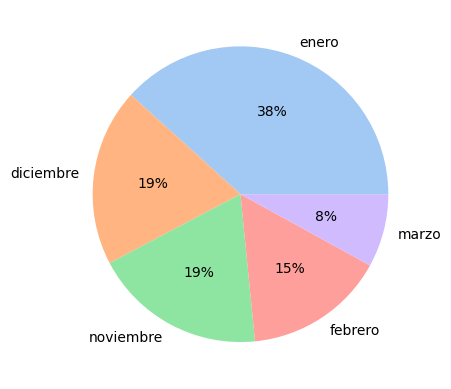

In [121]:
colors = sns.color_palette('pastel')[0:5]
labels = ['enero', 'diciembre', 'noviembre', 'febrero', 'marzo']
#create pie chart
plt.pie(tweets_per_month, labels = labels, colors = colors, autopct='%.0f%%')
plt.show();

- Podemos apreciar que en **enero** del presente año, fue el momento de mayor número de tweets.

d. *`¿Qué palabras son más frecuentes?`*

Creando una lista con todas las palabras en los tweets, eliminando las palabras vacías (stopwords), y luego contar cuántas veces aparece cada palabra en la lista, podemos conseguirlo. Las palabras con mayor frecuencia será la que buscamos.

In [127]:
stop_words = set(stopwords.words('spanish'))

all_words = []
for tweet in df['content']:
    for word in tweet.split():
        if word.lower() not in stop_words:
            all_words.append(word.lower())

word_counts = pd.Series(all_words).value_counts().sort_values(ascending=False)
word_counts.head(6)

@thebridge_tech    120
#bbkbootcamps       27
@bbk_eus            27
digital             27
bbk                 25
bootcamps           19
dtype: int64

- como podemos ver, las menciones y los hashtag son las palabras que más se repiten, por otro lado también tiene sentido, dado que es la 'etiqueta' que se le pone a cada tweet.

e. *`¿Qué tipo de correlación matemática encuentras entre las métricas públicas?`*

Usaremos la función de seaborn de correlación de Pearson:

C:\Users\Leandro\AppData\Local\Temp\ipykernel_16980\567930202.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True);


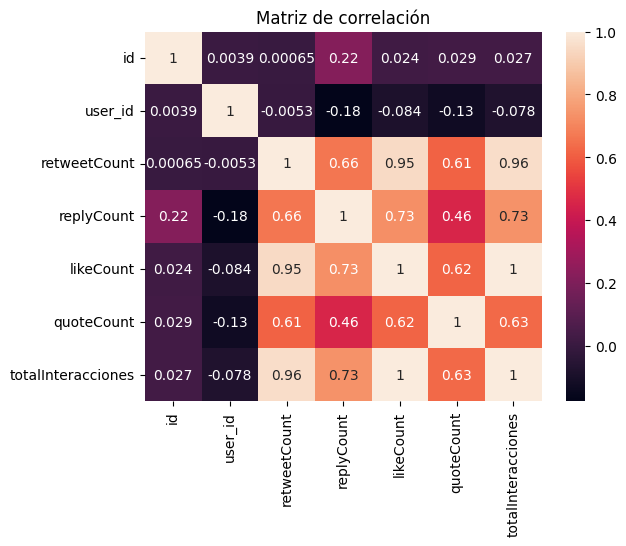

In [108]:
sns.heatmap(df.corr(), annot=True);
plt.title('Matriz de correlación');

Vemos varias relaciones fuertes:

- `likeCount` con `retweetCount` y `totalInteracciones`. Prácticamente se puede decir que si un tweet te ha gustado, lo vas a retweetear.
- `Retweet` con `reply`. Las respuestas y retweets implican comunicación y difusión de algo que para el usuario ha sido de interés.
- Podemos ver que la columna `quoteCount` y `replyCount` guardan una relación moderadamente fuerte, que por otra parte tiene sentido, ya que una es las veces que se contesta a un tweet, mientras que quoteCount es la cantidad de veces que se ha citado o retuiteado un tweet con un comentario y quizás no en todos los casos tenga que estar relacionado. 




f. *`¿Has sacado alguna conclusión extra en tu análisis?`*

Bueno... además del estudio realizado, se puede indagar un poquito más en la información que aporta esta librería, ya que, tal y como hemos visto, habían más parámetros interesantes como:

- `statusesCount` se refiere al número total de tweets publicados por la cuenta de Twitter a la que se refiere su user_id.
- `favouritesCount`: ésta, hace referencia al número de tweets que la cuenta ha marcado como favoritos.
- `listedCount`: Esta variable muestra el número de veces que la cuenta ha sido agregada a listas de usuarios de otros usuarios de Twitter.
- `mediaCount`: se refiere al número de medios (imágenes, videos, etc.) que la cuenta ha compartido en Twitter.

con estas variables, podríamos indagar en:

- Identificar a los usuarios con **mayor número de seguidores** que mencionan a la escuela y evaluar `la calidad de su engagement` (retweets, replies, likes, etc.) en comparación con el resto de usuarios.
- Identificar que tan el impacto que puede tener que una cuenta con muchos seguidores haga retweet al tweet de la escuela, lo que podría dar como dato el número de impresiones máximo (o repercusión máxima) que podría llegar a tener. 
- Claramente, el análisis de sentimiento sería lo indicado aquí, pero lo analizaremos en el siguiente punto. 
- entre otros, que no se abordan por falta de tiempo, pero cabría destacar:
  - Comparar el número de interacciones de los tweets promocionales de la escuela con los tweets informativos o de contenido para determinar qué tipo de contenido es más atractivo para la audiencia.
  - Evaluar la correlación entre el número de interacciones y el contenido del tweet, como la longitud del tweet, el uso de hashtags y menciones, y la presencia de imágenes o videos.

In [11]:
query = "(@TheBridge_Tech) until:2023-03-07 since:2022-11-21"

followers_dict = {
    'id': [],
    'user_id': [],
    'user_username': [],
    'user_displayname': [],
    'followersCount': [],
    'friendsCount': [],
    'statusesCount': [],
    'favouritesCount': [],
    'listedCount': [],
    'mediaCount': []
}

for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    followers_dict['id'].append(tweet.id)
    followers_dict['user_id'].append(tweet.user.id)
    followers_dict['user_username'].append(tweet.user.username)
    followers_dict['user_displayname'].append(tweet.user.displayname)
    followers_dict['followersCount'].append(tweet.user.followersCount)
    followers_dict['friendsCount'].append(tweet.user.friendsCount)
    followers_dict['statusesCount'].append(tweet.user.statusesCount)
    followers_dict['favouritesCount'].append(tweet.user.favouritesCount)
    followers_dict['listedCount'].append(tweet.user.listedCount)
    followers_dict['mediaCount'].append(tweet.user.mediaCount)

df_followers = pd.DataFrame(followers_dict)
df_followers


,id,user_id,user_username,user_displayname,followersCount,friendsCount,statusesCount,favouritesCount,listedCount,mediaCount
0,1632767114380492803,1162694149956603904,TheBridge_Tech,The Bridge,624,132,621,297,11,318
1,1632746286133702658,1162694149956603904,TheBridge_Tech,The Bridge,624,132,621,297,11,318
2,1632692123412594688,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,14,22,29,13,0,11
3,1632692120719859712,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,14,22,29,13,0,11
4,1632664546665025536,41545659,nodosenlared,Mario Lopez de Avila,6274,4656,16829,11236,574,3111
...,...,...,...,...,...,...,...,...,...,...
170,1595359906747617280,1162694149956603904,TheBridge_Tech,The Bridge,624,132,621,297,11,318
171,1594975696614526979,1162694149956603904,TheBridge_Tech,The Bridge,624,132,621,297,11,318
172,1594968601265586178,783248945761910788,HoplaSoftware,Hopla! Software,278,363,1277,818,40,848
173,1594965197613322241,702077405045899264,BBK_eus,Fundación BBK | Obra Social,1850,1131,5434,4305,34,3269


In [12]:
df_followers.to_csv('./data/followers.csv', encoding='utf-8', index=False)

In [114]:
df_followers.isnull().sum()

id                  0
user_id             0
user_username       0
user_displayname    0
followersCount      0
friendsCount        0
statusesCount       0
favouritesCount     0
listedCount         0
mediaCount          0
dtype: int64

In [13]:
# Unir las dos tablas a través de la columna 'id'
full_df = pd.merge(df, df_followers, on=['id','user_id','user_username','user_displayname'])

In [14]:
full_df.head()

,id,content,date,user_id,user_username,user_displayname,retweetCount,replyCount,likeCount,quoteCount,totalInteracciones,mes,followersCount,friendsCount,statusesCount,favouritesCount,listedCount,mediaCount
0,1632767114380492803,"¡Evento #desarrolloweb en #Sevilla con Diego Freniche Brito, Developer Advocate en @MongoDB!\n\nCambiamos de ubicación ¡Te esperamos en @espacio_RES!\n\n📅16 marzo\n⏰18 h\n📍En @espacio_RES \n\nEntradas 👉https://t.co/MJ21xSfIX0 https://t.co/bYJuYAaZ6N",2023-03-06 15:36:30+00:00,1162694149956603904,TheBridge_Tech,The Bridge,3,0,4,0,7,2023-03,624,132,621,297,11,318
1,1632746286133702658,"¡Súper contentos de participar! Las temáticas prometen, sin duda 🤩 ¡No te lo pierdas! \n\n📍Universidad @pablodeolavide Sevilla\n🎟Entradas https://t.co/jFvxqPvKTO",2023-03-06 14:13:44+00:00,1162694149956603904,TheBridge_Tech,The Bridge,1,0,1,0,2,2023-03,624,132,621,297,11,318
2,1632692123412594688,Las inscripciones se realizarán por Eventbrite. Cualquier duda estamos por MD o al correo info@esoliupo.es\nhttps://t.co/xhVr7VXcF3\n\n@epsUPO @TheBridge_Tech,2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,0,0,0,0,0,2023-03,14,22,29,13,0,11
3,1632692120719859712,"¡Por fin podemos publicar el cartel con los ponentes para el #cybersecTalks! Si estás interesadx en alguna de las temáticas que aparecen no dudes en venir, es totalmente gratuito gracias al patrocinio de @TheBridge_Tech y la colaboración de @epsUPO @pablodeolavide \n(+ info abajo) https://t.co/JF85MDGmXc",2023-03-06 10:38:30+00:00,1585726199485140993,ESOLIUPO,Asociación de Estudiantes de Software Libre UPO,3,1,5,1,10,2023-03,14,22,29,13,0,11
4,1632664546665025536,"Encuentro de la @mlopscommunity en Madrid: ""MLOPs: desde las trincheras"" https://t.co/CHojEAs7ij en @TheBridge_Tech Ven a conocer la práctica #MLOps en Correcto., @Busuu @wallapop https://t.co/odie5CAuHU",2023-03-06 08:48:56+00:00,41545659,nodosenlared,Mario Lopez de Avila,1,0,3,0,4,2023-03,6274,4656,16829,11236,574,3111


- Ahora filtramos las filas donde la columna '`content`' contenga la mención a "@TheBridge_Tech"

In [126]:
filtro = full_df['content'].str.contains('@TheBridge_Tech')
resultados = full_df[filtro]
resultados = resultados.sort_values(by='followersCount', ascending=False)
resultados[['user_username', 'followersCount', 'totalInteracciones']].drop_duplicates(subset='user_username').head()

,user_username,followersCount,totalInteracciones
77,Godivaciones,39687,3
117,radiovalencia,25261,7
80,Recuenco,23813,43
16,Metricool_es,21329,3
41,Ari_Reinventada,19147,2


- Aquí podemos ver como las cuentas de los usuarios: `Godivaciones`, `radiovalencia`, `Recuenco`, `Metricool_es` y `Ari_Reinventada` (esta última yo la conozco xD) son las que más nos interesa que interaccione con nosotros, ya que son los que más repercusión nos harían ganar.

De hecho, si sumamos las cantidades de seguidores, se puede afirmar que la repercusión máxima que pudo llegar a tener el tweet, además de sus propios seguidores, ha sido `129237`. 

Además, se puede ver que el usuario '`Recuenco`' es el que más veces ha interaccionado con la escuela. (¿Se le está pagando? xD)

![El señor Recuenco](./assets/Recuenco1.jpg)
![Un gran amigo de la escuela](./assets/Recuenco2.jpg)


**Lo dicho, la escuela le debe una cervecilla a este buen hombre, que él solito le proporcionó un número potencial de impresiones de `1.023.959` en tan solo 4 meses.**



cabe destacar que el contenido de la campaña debe ser relevante y atractivo para el público objetivo. Debe ser informativo, entretenido y proporcionar valor al usuario, por lo que no necesariamente es ese el número de impresiones totales reales, por eso mismo lo nombro "potencial". 

###  Promedio de interacciones por tweet:

In [130]:
interacciones_promedio = full_df['totalInteracciones'].mean()
round(interacciones_promedio,2)

7.05

- Esto podríamos intentar mejorarlo.

### Tweet con más interacciones:

In [135]:
tweet_mas_interacciones = full_df.loc[full_df['totalInteracciones'].idxmax()]
pd.DataFrame(tweet_mas_interacciones)

,87
id,1614612463361695747
content,"Advanced #Cynefin, Estuarine mapping &amp; EUFG Masterclass (Madrid) https://t.co/H5ZSjbKHAr | Los interesados en la aplicación de las ciencias de la complejidad en nuestro país tendremos la oportunidad de aprender de @snowded en persona el 16/3/23 en la sede de @TheBridge_Tech https://t.co/LavCfgYIht"
date,2023-01-15 13:16:23+00:00
user_id,41545659
user_username,nodosenlared
user_displayname,Mario Lopez de Avila
retweetCount,49
replyCount,7
likeCount,322
quoteCount,4


- `322 likes!, casi 50 RT`, parece que la escuela debe intentar **ampliar sus colaboraciones con profesionales del sector**, ya que es tema que a su público objetivo le interesa.

#### **Cabe destacar que este tweet ha sido el que más likes, más menciones a la escuela, más respuestas y más retweets ha tenido la escuela en los 4 meses.**

### El tweet con más menciones a otros usuarios:

In [147]:
tweet_mas_menciones = full_df.loc[full_df['mediaCount'].idxmax()]
pd.DataFrame(tweet_mas_menciones)


,131
id,1599831430288359449
content,"guillerdorron: RT @BBK_eus: Tras la presentación de la nueva edición de #BBKBootcamps realizada en colaboración con @TheBridge_Tech en la torre @BAT_Tower, pudimos charlar con @guillerdorron \n de @Zabala_IC sobre cómo potenciar el #talento actual y cuále… https://t.co/NEbbBGGc1x"
date,2022-12-05 18:21:51+00:00
user_id,146406912
user_username,EditaOla
user_displayname,Edita Olaizola
retweetCount,0
replyCount,0
likeCount,1
quoteCount,0


- Aquí nombramos a muchas personas! Pero lastimosamente no ha tenido gran repercusión.

A partir de estos análisis adicionales, se pueden sacar conclusiones como las siguientes:

    La escuela tiene una audiencia comprometida y activa (pero no mucha cantidad) en las redes sociales, lo que indica que las estrategias de marketing y comunicación están funcionando bien, pero se debe plantear campañas para crecer en seguidores y embajadores de la marca.

    Los eventos y las promociones son los temas más populares y generan la mayor cantidad de interacciones, por lo que la escuela debería enfocarse en la organización de más eventos y promociones para atraer a más audiencia.

    La mayoría de los tweets tienen un sentimiento positivo, lo que sugiere que la percepción de la audiencia hacia la escuela es positiva en general.
    
    Los tweets más populares suelen tener una longitud media, con el uso adecuado de hashtags y menciones, y a menudo incluyen imágenes o videos, lo que sugiere que el contenido visual y la calidad del copywriting son importantes para la interacción de los usuarios.

## Predicciones de modelo ML

### Limpieza de datos

In [15]:
# Definición de diccionario que contiene los emojis más comunes con sus significados.

emojis = {':)': 'sonrisa', ':-)': 'sonrisa', ';d': 'guiño', ':-E': 'vampiro', ':(': 'triste',
           ':-(': 'triste', ':-<': 'triste', ':P': 'frambuesa', ':O': 'sorprendido',
           ':-@': 'conmocionado', ':@': 'conmocionado',':-$': 'confundido', ':\\': 'molesto',
           ':#': 'silencio', ':X': 'silencio', ':^)': 'sonrisa', ':-&': 'confundido', '$_$': 'codicioso',
           '@@': 'ojos en blanco', ':-!': 'confundido', ':-D': 'sonrisa', ':-0': 'gritar', 'O.o': 'confundido',
           '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'triste sonrisa', ';)': 'guiño',
           ';-)': 'guiño', 'O:-)': 'ángel','O*-)': 'ángel','(:-D': 'chisme', '=^.^=' : 'gato', '\U0001f4cd': 'chincheta redonda',
           '\U0001f4c5':'calendario', '\U0001f4c6':'calendario recordable', '\U0001f449':'mano indice derecha', '\u23F0':'despertador'}

- Eliminamos los signos de puntuación:

In [30]:
signos = re.compile("(\.)|(\;)|(\:)|(\!)|(\¡)|(\?)|(\#)|(\¿)|(\@)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)|(\n+)|(https?://\S+)|(https?://\S+(?:\s|\W|$))|(\b\w+://\S+)|([^a-zA-Z0-9áéíóúüñÁÉÍÓÚÜÑ]+ " ")")

In [31]:
full_df_ml = full_df.copy()

In [32]:
def signs_tweets(tweet):
    return signos.sub(' ', tweet.lower())

full_df_ml['content'] = full_df_ml['content'].apply(signs_tweets)
full_df_ml['content'].head()

0                                                                                           evento  desarrolloweb en  sevilla con diego freniche brito  developer advocate en  mongodb  cambiamos de ubicación  te esperamos en  espacio_res  📅  marzo ⏰  h 📍en  espacio_res  entradas 👉   
1                                                                                                                                                      súper contentos de participar  las temáticas prometen  sin duda  no te lo pierdas   📍universidad  pablodeolavide sevilla 🎟entradas  
2                                                                                                                                                      las inscripciones se realizarán por eventbrite  cualquier duda estamos por md o al correo info esoliupo es    epsupo  thebridge_tech
3     por fin podemos publicar el cartel con los ponentes para el  cybersectalks  si estás interesadx en alguna de las temáticas que aparecen no dud

"intentamos" quitar los emojis...

In [33]:
def clean_emoji(tweet):
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, " EMOJI " + emojis[emoji])
        return tweet

full_df_ml['content'] = full_df_ml['content'].apply(clean_emoji)
full_df_ml['content'].head()

0                                                                                           evento  desarrolloweb en  sevilla con diego freniche brito  developer advocate en  mongodb  cambiamos de ubicación  te esperamos en  espacio_res  📅  marzo ⏰  h 📍en  espacio_res  entradas 👉   
1                                                                                                                                                      súper contentos de participar  las temáticas prometen  sin duda  no te lo pierdas   📍universidad  pablodeolavide sevilla 🎟entradas  
2                                                                                                                                                      las inscripciones se realizarán por eventbrite  cualquier duda estamos por md o al correo info esoliupo es    epsupo  thebridge_tech
3     por fin podemos publicar el cartel con los ponentes para el  cybersectalks  si estás interesadx en alguna de las temáticas que aparecen no dud

In [46]:
full_df_ml["idioma"] = full_df_ml["content"].apply(lambda x: detect(x))

In [35]:
print('El número de tweets que no reconoce como español son',len(full_df_ml.loc[full_df_ml.idioma != 'es'][['content']]), '\n')
full_df_ml.loc[full_df_ml.idioma != 'es'][['content']]

El número de tweets que no reconoce como español son 27 



,content
6,paumugarra tonidorta thebridge_tech
13,thebridge_tech vacolba interesante
20,thebridge_tech vacolba andresmacariog interesante
30,globalgamejam en urdulizftef organizado con la colaboración de digipenbilbao y bbk bootcamps by thebridge_tech jammers h non stop quieres saber más sobre este eventazo visita nuestra web ggj ftef ggj videogames hackathon
32,inicia masterclass datascience una ia para gobernarlos a todos thebridge_tech bbk_kuna bbk_eus ai chatgpt nlp
33,masterclass en data science de los bootcamps de bbk powered by thebridge_tech artificalintelligence chatgpt
37,interesantísima jornada de proptechthursdays con thefringelabs davidhueso propper hanok casafarire intrumes thebridge_tech
45,jorgegrev was one of the reasons i got into community he has built countless communities/initiatives brought tons of new folks into the ecosystem he's currently rocking the bbk_eus bootcamp with thebridge_tech helping unemployed people learn tech
56,os esperamos en bbk_kuna apúntate ya bbkbootcampspoweredbythebridge bbk_eus
65,te gustaría codear como un profesional ven a la masterclass de desarrollo web full stack bilbao con bbk_eus save the date 📆 ene ⏰ h 🏰en bbk_kuna apúntate desarrollowebfullstack bbkbootcampspoweredbythebridge fullstack bootcamp


In [29]:
full_df_ml.loc[full_df_ml.idioma != 'es'][['content']].index

Int64Index([  6,  11,  13,  20,  23,  32,  33,  37,  45,  56,  65,  71,  80,
             95, 123, 127, 138, 142, 144, 145, 148, 151, 153, 155, 157, 159,
            161, 173],
           dtype='int64')

In [37]:
indices_a_traducir = [ 6, 11, 13, 20, 23, 45, 56, 65, 123, 127, 138, 142, 144, 145, 148, 151, 153, 155, 157, 159, 161, 173]

translator = Translator()

def traducir_fila(row):
    if row.name in indices_a_traducir:
        translated_text = translator.translate(row['content'], src='eu', dest='es').text
        return translated_text
    else:
        return row['content']

# Aplica la función de traducción a las filas seleccionadas
full_df_ml['content'] = full_df_ml.apply(traducir_fila, axis=1)


In [40]:
print('El número de tweets que no reconoce como español son',len(full_df_ml.loc[full_df_ml.idioma != 'es'][['content']]), '\n')
full_df_ml.loc[full_df_ml.idioma != 'es'][['content']]

El número de tweets que no reconoce como español son 16 



,content
11,Descentralized_b bitcointuesday thebridge_tech ¿miniscrito de suspens?
13,TheBridge_Tech Vacolba interesante
20,TheBridge_Tech Vacolba y Selomacariog Interesante
32,inicia masterclass datascience una ia para gobernarlos a todos thebridge_tech bbk_kuna bbk_eus ai chatgpt nlp
33,masterclass en data science de los bootcamps de bbk powered by thebridge_tech artificalintelligence chatgpt
37,interesantísima jornada de proptechthursdays con thefringelabs davidhueso propper hanok casafarire intrumes thebridge_tech
39,hoy a las en bbk_kuna masterclass sobre inteligencia artificial chatgpt y otras ias también explicaremos el bootcamp de datascience en bilbao bbknetwork bbk_eus thebridge_tech
65,Te Gustaria Codear como como.
71,recuenco ae_bm thebridge_tech ddamasd ✌️
80,en plena meet-up de cps en thebridge_tech con ddamasd


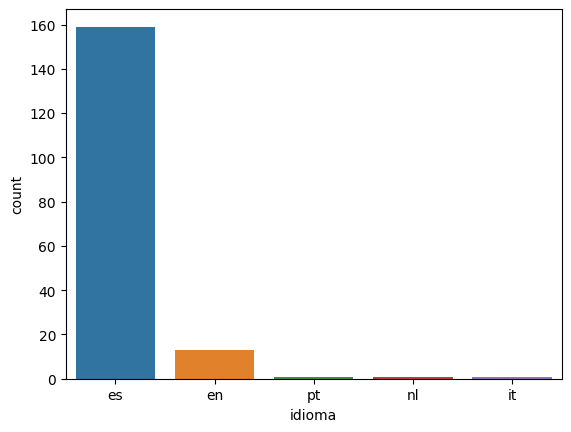

In [41]:
sns.countplot(x="idioma", data=full_df_ml);

Según la librería, tenemos la gran mayoría de tweets en español, el siguiente más utilizado sería en inglés, y luego detecta "nl" e "id", que son holandes e indonesio respectivamente, pero voy a revisar si es así o no, ya que me suena a que realmente es Euskera:

In [43]:
full_df_ml.loc[full_df_ml.idioma == 'en'][['content']].index

Int64Index([11, 13, 20, 32, 33, 37, 39, 71, 93, 123, 127, 145, 150], dtype='int64')

In [44]:
indices_a_traducir = [ 11, 13, 20, 32, 33, 37, 39, 71, 93, 123, 127, 145, 150]

translator = Translator()

def traducir_fila(row):
    if row.name in indices_a_traducir:
        translated_text = translator.translate(row['content'], src='en', dest='es').text
        return translated_text
    else:
        return row['content']

# Aplica la función de traducción a las filas seleccionadas
full_df_ml['content'] = full_df_ml.apply(traducir_fila, axis=1)

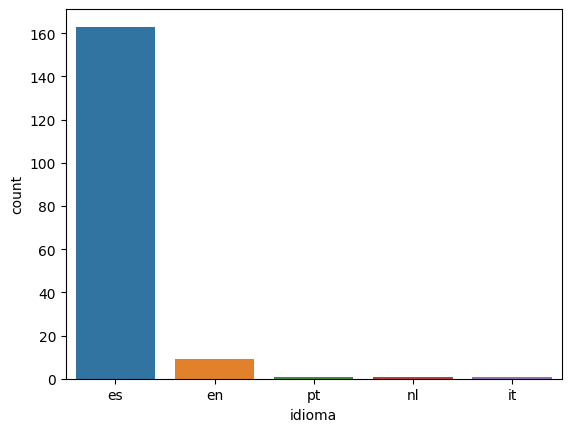

In [47]:
sns.countplot(x="idioma", data=full_df_ml);

- Descargamos los stopwords de la librería **nltk**

In [48]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leandro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:

stop_words = stopwords.words('spanish')

In [50]:
print(stop_words)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

In [51]:
def remove_stopwords(df):
    return " ".join([word for word in df.split() if word not in stop_words])

In [54]:
full_df_ml['content'] = full_df_ml['content'].apply(remove_stopwords)
full_df_ml.head(2)

,id,content,date,user_id,user_username,user_displayname,retweetCount,replyCount,likeCount,quoteCount,totalInteracciones,mes,followersCount,friendsCount,statusesCount,favouritesCount,listedCount,mediaCount,idioma
0,1632767114380492803,evento desarrolloweb sevilla diego freniche brito developer advocate mongodb cambiamos ubicación esperamos espacio_res 📅 marzo ⏰ h 📍en espacio_res entradas 👉,2023-03-06 15:36:30+00:00,1162694149956603904,TheBridge_Tech,The Bridge,3,0,4,0,7,2023-03,624,132,621,297,11,318,es
1,1632746286133702658,súper contentos participar temáticas prometen duda pierdas 📍universidad pablodeolavide sevilla 🎟entradas,2023-03-06 14:13:44+00:00,1162694149956603904,TheBridge_Tech,The Bridge,1,0,1,0,2,2023-03,624,132,621,297,11,318,es


Utilizando el método `stem()` de la clase **SnowballStemmer** para obtener la forma base de una palabra en español.

In [55]:
# Instanciar el stemmer para español
stemmer = SnowballStemmer('spanish')

# Definir una función para lematizar todo el texto
def lemmatize_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

# Aplicar la lematización a la columna 'texto'
full_df_ml['texto_lemmatizado'] = full_df_ml['content'].apply(lemmatize_text)

In [56]:
full_df_ml.head(2)

,id,content,date,user_id,user_username,user_displayname,retweetCount,replyCount,likeCount,quoteCount,totalInteracciones,mes,followersCount,friendsCount,statusesCount,favouritesCount,listedCount,mediaCount,idioma,texto_lemmatizado
0,1632767114380492803,evento desarrolloweb sevilla diego freniche brito developer advocate mongodb cambiamos ubicación esperamos espacio_res 📅 marzo ⏰ h 📍en espacio_res entradas 👉,2023-03-06 15:36:30+00:00,1162694149956603904,TheBridge_Tech,The Bridge,3,0,4,0,7,2023-03,624,132,621,297,11,318,es,event desarrolloweb sevill dieg frenich brit develop advocat mongodb cambi ubic esper espacio_r 📅 marz ⏰ h 📍en espacio_r entrad 👉
1,1632746286133702658,súper contentos participar temáticas prometen duda pierdas 📍universidad pablodeolavide sevilla 🎟entradas,2023-03-06 14:13:44+00:00,1162694149956603904,TheBridge_Tech,The Bridge,1,0,1,0,2,2023-03,624,132,621,297,11,318,es,sup content particip temat promet dud pierd 📍univers pablodeolavid sevill 🎟entr


In [79]:
df_ml = full_df_ml[['content','texto_lemmatizado']]

In [58]:
df_ml.to_csv('./data/df_ml.csv', encoding='utf-8', index=False)

- Importamos el modelo:

In [59]:
with open('./model/sentiment_model', "rb") as archivo_entrada:
    pipeline_importada = pickle.load(archivo_entrada)

c:\Users\Leandro\Documents\DATA SCIENCE THE BRIDGE\ds_thebridge_11_22-main\Alumno\5-Orientation\Technical_test\Analisis_sentimientos__twitter\env\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator CountVectorizer from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\Leandro\Documents\DATA SCIENCE THE BRIDGE\ds_thebridge_11_22-main\Alumno\5-Orientation\Technical_test\Analisis_sentimientos__twitter\env\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnin

La advertencia indica que se está intentando deserializar un objeto (en este caso el modelo para la predicción) creado con una versión anterior de la biblioteca Scikit-learn (versión 1.0.2) en un entorno que utiliza una versión más reciente de la biblioteca (en este caso, la versión 1.2.1). Esto puede generar resultados incorrectos o errores en el código.

Esta advertencia se genera porque Scikit-learn no garantiza la compatibilidad de los modelos entrenados en diferentes versiones de la biblioteca.

Para resolver esta advertencia, se recomienda recrear el modelo de Machine Learning en la versión actual de Scikit-learn para evitar posibles errores en el código.

----------

Lo probaré, si veo que da fallos, intentaré con otro modelo de predicción.

In [60]:
pipeline_importada

Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=1000, min_df=5,
                                 ngram_range=(1, 2))),
                ('cls', LogisticRegression(C=0.5))])

In [80]:
predictions = pipeline_importada.predict(df_ml['texto_lemmatizado'])
df_ml['Polarity'] = pd.Series(predictions)
df_ml

C:\Users\Leandro\AppData\Local\Temp\ipykernel_14528\3806583245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['Polarity'] = pd.Series(predictions)


,content,texto_lemmatizado,Polarity
0,evento desarrolloweb sevilla diego freniche brito developer advocate mongodb cambiamos ubicación esperamos espacio_res 📅 marzo ⏰ h 📍en espacio_res entradas 👉,event desarrolloweb sevill dieg frenich brit develop advocat mongodb cambi ubic esper espacio_r 📅 marz ⏰ h 📍en espacio_r entrad 👉,0
1,súper contentos participar temáticas prometen duda pierdas 📍universidad pablodeolavide sevilla 🎟entradas,sup content particip temat promet dud pierd 📍univers pablodeolavid sevill 🎟entr,1
2,inscripciones realizarán eventbrite cualquier duda md correo info esoliupo epsupo thebridge_tech,inscripcion realiz eventbrit cualqui dud md corre info esoliup epsup thebridge_tech,0
3,fin podemos publicar cartel ponentes cybersectalks si interesadx alguna temáticas aparecen dudes venir totalmente gratuito gracias patrocinio thebridge_tech colaboración epsupo pablodeolavide info abajo,fin pod public cartel ponent cybersectalks si interesadx algun temat aparec dud ven total gratuit graci patrocini thebridge_tech colabor epsup pablodeolavid info abaj,0
4,encuentro mlopscommunity madrid mlops trincheras thebridge_tech ven conocer práctica mlops correcto busuu wallapop,encuentr mlopscommunity madr mlops trincher thebridge_tech ven conoc practic mlops correct busuu wallapop,1
...,...,...,...
170,ven conocer bbk bootcamps powered by thebridge_tech bbk_eus próximo open day🤗 📅 dic ⏰ bbk_kuna urazurrutia kalea bilbao lánzate carrera digital 🎟entradas uxui ciber desarrollowebfullstack datascience,ven conoc bbk bootcamps power by thebridge_tech bbk_eus proxim open day🤗 📅 dic ⏰ bbk_kun urazurruti kale bilba lanzat carrer digital 🎟entr uxui cib desarrollowebfullstack datascienc,1
171,hoplasoftware deseando teneros hoplasoftware recruiterscorner hablando cloud talentodigital 🙌,hoplasoftwar des tener hoplasoftwar recruiterscorn habl cloud talentodigital 🙌,1
172,acelerando juntos talentodigital españa próximo noviembre ceo juan zamora presentará hopla instalaciones thebridge_tech h contaremos quiénes hacemos cómo desarrollar carrerarofesional fructífera,aceler junt talentodigital españ proxim noviembr ceo juan zamor present hopl instal thebridge_tech h cont quien hac com desarroll carrerarofesional fructifer,1
173,"Aprenda registrarse futuros oficios BBKBOOTCAMP TheBridge_Tech, aprenderá diseño cita cibernética cybersecuridad cibernética diseño productos digitales UI desarrollo UX.","aprend registr futur ofici bbkbootcamp thebridge_tech, aprend diseñ cit cibernet cybersecur cibernet diseñ product digital ui desarroll ux.",0


In [64]:
np.array(df_ml['Polarity'])

array([0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0],
      dtype=int64)

In [65]:
df_ml['Polarity'].value_counts()

0    125
1     50
Name: Polarity, dtype: int64

In [81]:
predicions_proba = pipeline_importada.predict_proba(df_ml['texto_lemmatizado'])
predicions_proba

array([[7.21942158e-01, 2.78057842e-01],
       [4.35578663e-01, 5.64421337e-01],
       [5.74705727e-01, 4.25294273e-01],
       [8.79538265e-01, 1.20461735e-01],
       [3.57025945e-01, 6.42974055e-01],
       [8.97233227e-01, 1.02766773e-01],
       [5.47458527e-01, 4.52541473e-01],
       [9.01649693e-01, 9.83503074e-02],
       [9.69076260e-01, 3.09237395e-02],
       [6.14121084e-01, 3.85878916e-01],
       [4.26946107e-01, 5.73053893e-01],
       [5.47458527e-01, 4.52541473e-01],
       [7.50510111e-01, 2.49489889e-01],
       [7.06609477e-01, 2.93390523e-01],
       [9.18600677e-01, 8.13993234e-02],
       [1.49696147e-01, 8.50303853e-01],
       [5.54056771e-01, 4.45943229e-01],
       [8.07357931e-01, 1.92642069e-01],
       [9.70588596e-01, 2.94114043e-02],
       [7.88554400e-01, 2.11445600e-01],
       [7.06609477e-01, 2.93390523e-01],
       [3.08914903e-01, 6.91085097e-01],
       [8.41031989e-01, 1.58968011e-01],
       [6.70906735e-01, 3.29093265e-01],
       [9.811649

### Sorpresa en la predicción...

El análisis de sentimiento realizado sugiere que la mayoría de los tweets (125 de 175) tienen una polaridad con tendencia negativa. Esto podría indicar que la cuenta de Twitter de The Bridge está publicando contenido que utiliza palabras de cierta neutralidad, que hacen que no se pueda inclinar de manera correcta la balanza hacia el lado positivo.

Entra en constraste también el hecho de que con el análisis de los datos previos, pensamos que la mayoría son positivos, pero no se utiliza un lenguaje que sea mayoritariamente positivo, sino más bien neutro (puede ser que sean mensajes muy profesionales o con mucha información comprimida en varias menciones, RT, links, en euskera, etc...) 


b. *`¿Qué variables son las más importantes del modelo?`*

In [70]:
params = pipeline_importada.get_params()
print(params.keys())


dict_keys(['memory', 'steps', 'verbose', 'vect', 'cls', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'cls__C', 'cls__class_weight', 'cls__dual', 'cls__fit_intercept', 'cls__intercept_scaling', 'cls__l1_ratio', 'cls__max_iter', 'cls__multi_class', 'cls__n_jobs', 'cls__penalty', 'cls__random_state', 'cls__solver', 'cls__tol', 'cls__verbose', 'cls__warm_start'])


In [104]:

# Ajustamos el transformador de características y el clasificador del pipeline
vectorizer = pipeline_importada.named_steps['vect']
classifier = pipeline_importada.named_steps['cls']


# Sacamos el vocabulario del transformador
vocabulary = vectorizer.vocabulary_

# Crea un objeto CountVectorizer con el vocabulario
count_vectorizer = pipeline_importada['vect']

feature_mapping = {v: k for k, v in pipeline_importada['vect'].vocabulary_.items()}
eli5.show_weights(classifier, 
                  vec=count_vectorizer, 
                  feature_names=feature_mapping, 
                  top=30,
                  )

Weight?,Feature
+1.427,cuent
+1.402,deficit
+1.369,blanc
+1.350,muert
+1.343,conden
+1.342,denunci
+1.319,recort
+1.315,indign
+1.310,critic
+1.270,cos


Este resultado muestra las palabras más importantes para el modelo al predecir tweets positivos o negativos. 

Las palabras que tienen un peso positivo más alto (en el lado rojo de la tabla) indican que son las características más importantes para predecir un tweet positivo. Por otro lado, las palabras que tienen un peso negativo más alto (en el lado verde de la tabla) son las características más importantes para predecir un tweet negativo.

Por ejemplo, las palabras "cuent", "deficit", "blanc", "muert" y "conden" tienen un peso negativo alto, lo que indica que son palabras que aparecen con más frecuencia en los tweets negativos. Por otro lado, palabras como "felic", "regal", "estren", "maravill" y "alejandrosanz" tienen un peso positivo alto, lo que indica que son palabras que aparecen con más frecuencia en los tweets positivos.

Es importante destacar que no logré entender porqué salen graficados de manera inversa los valores, poniendo el verde los valores negativos y en rojo los positivos. Intentaré corregirlo con más tiempo y calma.

**Con lo que me quedo? que al modelo le gusta `Alejandro Sanz` :P**






c. *`¿Cómo podrías mejorar el modelo?`*

Se podría aumentar el corpus del entrenamiento, que puede añadirle un poco más de precisión. 

Podríamos ajustar los hiperparámetros y tratar de hacer un gridSearch para poder encontrar la mejor combinación de parámetros predictores.

Podríamos probar otros modelos como TextBlob, que fue el que usé para mi proyecto de ML.



d. *`¿Qué otras oportunidades se te ocurren donde se podrían aplicar otros
modelos de ML?`*

Existen muchas oportunidades!!

Nos hemos cansado en clase de ver diferentes aplicaciones y funcionalidades que podrían tener... 

- Aplicación a la medicina, con el reconocimiento de tumores, que ya se está estudiando...
- Sistemas de recomendación, para las empresas es un gran aliciente poder recomendar el mejor producto a sus clientes, para dar un servicio más personalizado. 
- NLP, no solo para lo que lo hemos usado en este trabajo, sino también para traducción automática, como DeepL, o ChatGPT, extracción de información de manera automática... etc.
- Predicciones para la bolsa, con los modelos de regresión, y análisis de series temporales... 

Realmente, el es un lienzo en blanco, podemos innovar casi en cualquier dirección. 